#**Training d-DNN and e-DNNs using DPR coincidences over the coast**

In [ ]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import h5py
import tensorflow as tf
import os

In [ ]:
f = h5py.File('Data/Dictionaries/Dic_DPR_coast.mat','r')
list(f.keys())

['X_coast_trn_detection',
 'X_coast_tst_detection',
 'X_rain_coast_trn_retrieval',
 'X_rain_coast_tst_retrieval',
 'X_snow_coast_trn_retrieval',
 'X_snow_coast_tst_retrieval',
 'y_coast_trn_detection',
 'y_coast_tst_detection',
 'y_rain_coast_trn_retrieval',
 'y_rain_coast_tst_retrieval',
 'y_snow_coast_trn_retrieval',
 'y_snow_coast_tst_retrieval']

In [ ]:
X1_trn_detection = np.transpose(f['X_coast_trn_detection'])
y_trn_detection = np.transpose(f['y_coast_trn_detection'])
X1_tst_detection = np.transpose(f['X_coast_tst_detection'])
y_tst_detection = np.transpose(f['y_coast_tst_detection'])

X1_rain_trn_retrieval = np.transpose(f['X_rain_coast_trn_retrieval'])
y_rain_trn_retrieval = np.transpose(f['y_rain_coast_trn_retrieval'])
X1_rain_tst_retrieval = np.transpose(f['X_rain_coast_tst_retrieval'])
y_rain_tst_retrieval = np.transpose(f['y_rain_coast_tst_retrieval'])

X1_snow_trn_retrieval = np.transpose(f['X_snow_coast_trn_retrieval'])
y_snow_trn_retrieval = np.transpose(f['y_snow_coast_trn_retrieval'])
X1_snow_tst_retrieval = np.transpose(f['X_snow_coast_tst_retrieval'])
y_snow_tst_retrieval = np.transpose(f['y_snow_coast_tst_retrieval'])

In [ ]:
X1_trn_detection.astype('float64')
X1_tst_detection.astype('float64')
y_trn_detection.astype('int64')
y_tst_detection.astype('int64')

X1_rain_trn_retrieval.astype('float64')
X1_rain_tst_retrieval.astype('float64')
y_rain_trn_retrieval.astype('float64')
y_rain_tst_retrieval.astype('float64')

X1_snow_trn_retrieval.astype('float64')
X1_snow_tst_retrieval.astype('float64')
y_snow_trn_retrieval.astype('float64')
y_snow_tst_retrieval.astype('float64');

### **1.2 Data Normalizing**

The input features for training have different ranges and units, therefore they need to be scaled to make the flow of the gradient decsent smooth and help the algorithm quickly reaches the optimal point of the cost function. Without scaling features, the algorithm may be biased toward those features which have larger magnitues. We used the following standardization:

$X_i^{\prime} = \frac{X_i - \mu}{σ}$

In the above equation $X_i^{\prime}$ is the scaled feature, $μ$ is the mean, and $σ$ is the standard deviation of the feature. In the next cell, we implement this scaling for the data sets.

In [ ]:
mean_detection = X1_trn_detection.mean(axis=0)
X2_trn_detection = X1_trn_detection-mean_detection
std_detection = X1_trn_detection.std(axis=0)
X_trn_detection = X2_trn_detection/std_detection
X2_tst_detection = X1_tst_detection-mean_detection
X_tst_detection = X2_tst_detection/std_detection

mean_rain_retrieval = X1_rain_trn_retrieval.mean(axis=0)
X2_rain_trn_retrieval = X1_rain_trn_retrieval-mean_rain_retrieval
std_rain_retrieval = X1_rain_trn_retrieval.std(axis=0)
X_rain_trn_retrieval = X2_rain_trn_retrieval/std_rain_retrieval
X2_rain_tst_retrieval = X1_rain_tst_retrieval-mean_rain_retrieval
X_rain_tst_retrieval = X2_rain_tst_retrieval/std_rain_retrieval

mean_snow_retrieval = X1_snow_trn_retrieval.mean(axis=0)
X2_snow_trn_retrieval = X1_snow_trn_retrieval-mean_snow_retrieval
std_snow_retrieval = X1_snow_trn_retrieval.std(axis=0)
X_snow_trn_retrieval = X2_snow_trn_retrieval/std_snow_retrieval
X2_snow_tst_retrieval = X1_snow_tst_retrieval-mean_snow_retrieval
X_snow_tst_retrieval = X2_snow_tst_retrieval/std_snow_retrieval

In [ ]:
# Removing the outliers
x_snow_lb = 0.01 #np.percentile(y_snow_trn_retrieval,0.05)
x_snow_ub = np.percentile(y_snow_trn_retrieval,99.95)

x_rain_lb = 0.01 #np.percentile(y_rain_trn_retrieval,0.05)
x_rain_ub = np.percentile(y_rain_trn_retrieval,99.95)

mask_trn_snow = (y_snow_trn_retrieval>=x_snow_lb) & (y_snow_trn_retrieval<=x_snow_ub)
m_trn_snow=mask_trn_snow[:,0]
mask_tst_snow = (y_snow_tst_retrieval>=x_snow_lb) & (y_snow_tst_retrieval<=x_snow_ub)
m_tst_snow=mask_tst_snow[:,0]

mask_trn_rain = (y_rain_trn_retrieval>=x_rain_lb) & (y_rain_trn_retrieval<=x_rain_ub)
m_trn_rain=mask_trn_rain[:,0]
mask_tst_rain = (y_rain_tst_retrieval>=x_rain_lb) & (y_rain_tst_retrieval<=x_rain_ub)
m_tst_rain=mask_tst_rain[:,0]

Xf_snow_trn_detection = np.delete(X_trn_detection, ~m_trn_snow, axis=0)
yf_snow_trn_detection = np.delete(y_trn_detection, ~m_trn_snow, axis=0)
Xf_snow_tst_detection = np.delete(X_tst_detection, ~m_tst_snow, axis=0)
yf_snow_tst_detection = np.delete(y_tst_detection, ~m_tst_snow, axis=0)

Xf_snow_trn_retrieval = np.delete(X_snow_trn_retrieval, ~m_trn_snow, axis=0)
yf_snow_trn_retrieval = np.delete(y_snow_trn_retrieval, ~m_trn_snow, axis=0)
Xf_snow_tst_retrieval = np.delete(X_snow_tst_retrieval, ~m_tst_snow, axis=0)
yf_snow_tst_retrieval = np.delete(y_snow_tst_retrieval, ~m_tst_snow, axis=0)

Xf_rain_trn_detection = np.delete(X_trn_detection, ~m_trn_rain, axis=0)
yf_rain_trn_detection = np.delete(y_trn_detection, ~m_trn_rain, axis=0)
Xf_rain_tst_detection = np.delete(X_tst_detection, ~m_tst_rain, axis=0)
yf_rain_tst_detection = np.delete(y_tst_detection, ~m_tst_rain, axis=0)

Xf_rain_trn_retrieval = np.delete(X_rain_trn_retrieval, ~m_trn_rain, axis=0)
yf_rain_trn_retrieval = np.delete(y_rain_trn_retrieval, ~m_trn_rain, axis=0)
Xf_rain_tst_retrieval = np.delete(X_rain_tst_retrieval, ~m_tst_rain, axis=0)
yf_rain_tst_retrieval = np.delete(y_rain_tst_retrieval, ~m_tst_rain, axis=0)

x_snow_lb, x_snow_ub, x_rain_lb, x_rain_ub

(0.01, 13.24145379142524, 0.01, 109.59234032238346)

To show that the labels are balanced in the training and test set, the number of snowfall, rainfall and no precipitation lables is printed in the next cell.

In [ ]:
print('***Training Dataset:\n')

n_snow=1
n_rain=1
n_clear=1  
t_train = np.zeros([y_trn_detection.shape[0],1])

for i in range(len(X_trn_detection)):
    label = y_trn_detection[i]
    if label==1:
        n_snow+=1
        t_train[i]=2
    if label==2:
        n_rain+=1  
        t_train[i]=1
    if label==3:
        n_clear+=1
        t_train[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

print('\n***Testing Dataset:\n')

n_snow=1
n_rain=1
n_clear=1  
t_test = np.zeros([y_tst_detection.shape[0],1])

for i in range(len(X_tst_detection)):
    label = y_tst_detection[i]
    if label==1:
        n_snow+=1
        t_test[i]=2
    if label==2:
        n_rain+=1  
        t_test[i]=1
    if label==3:
        n_clear+=1
        t_test[i]=0
        
print('Num. of snowfall:',n_snow)
print('Num. of rainfall:',n_rain)
print('Num. of clear-sky:',n_clear)

***Training Dataset:

Num. of snowfall: 175023
Num. of rainfall: 175161
Num. of clear-sky: 349819

***Testing Dataset:

Num. of snowfall: 75172
Num. of rainfall: 74613
Num. of clear-sky: 150218


In [ ]:
# Change the labels to catagorical

from tensorflow.keras.utils import to_categorical

t_trn_detection = to_categorical(t_train)
t_tst_detection = to_categorical(t_test)

# **2. Training the networks**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers, Sequential

### **2.1 - Detection Network (d-DNN)** 

In [ ]:
# Defining the architecture of the d-DNN network which has 6 layers and 30 hidden units in each layer.

# Parameters
hidden_units = 30
dropout = 0

# Detection Module
model_detection = Sequential()

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(hidden_units))
model_detection.add(Activation('relu'))
model_detection.add(Dropout(dropout))

model_detection.add(Dense(3))
model_detection.add(Activation('softmax'))

In [ ]:
# Compiling the model by defining the loss function and learning rate.

model_detection.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics= [tf.keras.metrics.Recall()])

In [ ]:
# Defining the callback list for early stoping and saving the model.

from tensorflow import keras
callbacks_list = [
#     keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     patience=25,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    save_best_only=True,
    )    
]

In [ ]:
print('\nFitting DNN (Detection Module):\n')
batch_size1 = 1800
history_detection = model_detection.fit(X_trn_detection, t_trn_detection, epochs=300,
                                validation_split=.2, batch_size = batch_size1,
                                callbacks=callbacks_list, verbose=1)


Fitting DNN (Detection Module):

Epoch 1/300
312/312 [==============================] - 1s 4ms/step - loss: 0.8444 - recall: 0.3152 - val_loss: 0.6077 - val_recall: 0.6789
Epoch 2/300
312/312 [==============================] - 1s 3ms/step - loss: 0.4905 - recall: 0.7663 - val_loss: 0.4162 - val_recall: 0.8148
Epoch 3/300
312/312 [==============================] - 1s 3ms/step - loss: 0.3863 - recall: 0.8299 - val_loss: 0.3596 - val_recall: 0.8435
Epoch 4/300
312/312 [==============================] - 1s 3ms/step - loss: 0.3464 - recall: 0.8503 - val_loss: 0.3304 - val_recall: 0.8580
Epoch 5/300
312/312 [==============================] - 1s 3ms/step - loss: 0.3245 - recall: 0.8615 - val_loss: 0.3164 - val_recall: 0.8657
Epoch 6/300
312/312 [==============================] - 1s 3ms/step - loss: 0.3121 - recall: 0.8680 - val_loss: 0.3093 - val_recall: 0.8703
Epoch 7/300
312/312 [==============================] - 1s 3ms/step - loss: 0.3042 - recall: 0.8720 - val_loss: 0.2996 - val_recall: 

312/312 [==============================] - 1s 3ms/step - loss: 0.2508 - recall: 0.8957 - val_loss: 0.2527 - val_recall: 0.8950
Epoch 118/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2506 - recall: 0.8956 - val_loss: 0.2518 - val_recall: 0.8949
Epoch 119/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2506 - recall: 0.8957 - val_loss: 0.2499 - val_recall: 0.8963
Epoch 120/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2505 - recall: 0.8956 - val_loss: 0.2597 - val_recall: 0.8914
Epoch 121/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2504 - recall: 0.8959 - val_loss: 0.2493 - val_recall: 0.8965
Epoch 122/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2504 - recall: 0.8959 - val_loss: 0.2502 - val_recall: 0.8962
Epoch 123/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2503 - recall: 0.8958 - val_loss: 0.2518 - val_recall: 0.8953
Epoch 124/300
312/312 [====

312/312 [==============================] - 1s 3ms/step - loss: 0.2448 - recall: 0.8979 - val_loss: 0.2458 - val_recall: 0.8983
Epoch 234/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2448 - recall: 0.8978 - val_loss: 0.2470 - val_recall: 0.8977
Epoch 235/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2448 - recall: 0.8979 - val_loss: 0.2491 - val_recall: 0.8966
Epoch 236/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2447 - recall: 0.8978 - val_loss: 0.2484 - val_recall: 0.8971
Epoch 237/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2447 - recall: 0.8977 - val_loss: 0.2448 - val_recall: 0.8987
Epoch 238/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2447 - recall: 0.8980 - val_loss: 0.2455 - val_recall: 0.8983
Epoch 239/300
312/312 [==============================] - 1s 3ms/step - loss: 0.2447 - recall: 0.8980 - val_loss: 0.2446 - val_recall: 0.8982
Epoch 240/300
312/312 [====

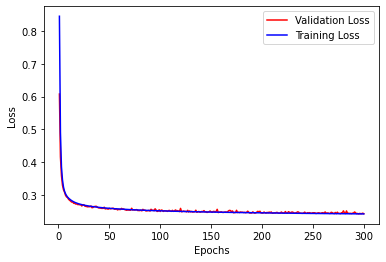

In [ ]:
# Plotting the variation of loss function on both training and validation set: 

import matplotlib.pyplot as plt

val_loss = history_detection.history["val_loss"]
loss = history_detection.history["loss"]

epochs = range(1, 301)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# Testing the trained network over the testset.

predictions_label = model_detection.predict(X_tst_detection)

y_pred = np.zeros([len(X_tst_detection),1])
for i in range(len(X_tst_detection)):
    y_pred[i,0] = np.argmax(predictions_label[i])
    


### Metrics

In [ ]:
### Detection Module

n_cc=1
n_cs=1
n_cr=1
n_sc=1
n_ss=1
n_sr=1
n_rc=1
n_rs=1
n_rr=1

precip_c= 3
precip_r= 2
precip_s= 1

for i in range(len(X_tst_detection)):
    label_predict = y_pred[i]
    label_actual = t_test[i]
    if label_predict==precip_c and label_actual==precip_c:
        n_cc+=1
    if label_predict==precip_s and label_actual==precip_s:
        n_ss+=1
    if label_predict==precip_r and label_actual==precip_r:
        n_rr+=1 
    if label_predict==precip_c and label_actual==precip_s:
        n_cs+=1
    if label_predict==precip_c and label_actual==precip_r:
        n_cr+=1
    if label_predict==precip_s and label_actual==precip_c:
        n_sc+=1
    if label_predict==precip_s and label_actual==precip_r:
        n_sr+=1  
    if label_predict==precip_r and label_actual==precip_c:
        n_rc+=1
    if label_predict==precip_r and label_actual==precip_s:
        n_rs+=1        
        
#Snow
TP_s = n_ss
TN_s = n_cc+n_cr+n_rc+n_rr
FP_s = n_sc+n_sr
FN_s = n_cs+n_rs

precision_s = TP_s/(TP_s+FP_s)
acc_s = (TP_s+TN_s)/(TP_s+TN_s+FP_s+FN_s)
recall_s = TP_s/(TP_s+FN_s)
f1_score_s = (2*precision_s*recall_s)/(precision_s+recall_s)
FPR_s = FP_s/(FP_s+TN_s)

#Rain
TP_r = n_rr
TN_r = n_cc+n_cs+n_sc+n_ss
FP_r = n_rc+n_rs
FN_r = n_cr+n_sr

precision_r = TP_r/(TP_r+FP_r)
acc_r = (TP_r+TN_r)/(TP_r+TN_r+FP_r+FN_r)
recall_r = TP_r/(TP_r+FN_r)
f1_score_r = (2*precision_r*recall_r)/(precision_r+recall_r)
FPR_r = FP_r/(FP_r+TN_r) 

print('\n For Rainfall Detection Over Coast:\n')
print('Precision: ',precision_r)
print('Accuracy: ',acc_r)
print('Recall (TPR): ',recall_r)
print('False Alarm (FPR): ',FPR_r)
print('\nF1 Score: ',f1_score_r)

print('----------------------------')
print('\n For Snwofall Detection Over Coast:\n')
print('Precision: ',precision_s)
print('Accuracy: ',acc_s)
print('Recall (TPR): ',recall_s)
print('False Alarm (FPR): ',FPR_s)
print('\nF1 Score: ',f1_score_s)

#Model
TP = n_cc+n_ss+n_rr
FP = n_cs+n_cr+n_sc+n_sr+n_rc+n_rs
FN = n_sc+n_rc+n_cs+n_rs+n_cr+n_sr

precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = (2*precision*recall)/(precision+recall)

print('----------------------------')
print('\n For Model Detection Over Coast:\n')
print('Precision: ',precision)
print('Recall (TPR): ',recall)
print('\nF1 Score: ',f1_score)


 For Rainfall Detection Over Coast:

Precision:  0.9229271348230456
Accuracy:  0.9393267166995578
Recall (TPR):  0.9608171134517515
False Alarm (FPR):  0.08286847923163643

F1 Score:  0.94149106113434
----------------------------

 For Snwofall Detection Over Coast:

Precision:  0.9577382954649705
Accuracy:  0.9393267166995578
Recall (TPR):  0.9171278807578552
False Alarm (FPR):  0.039181220231344974

F1 Score:  0.9369932685115931
----------------------------

 For Model Detection Over Coast:

Precision:  0.939312311836476
Recall (TPR):  0.939312311836476

F1 Score:  0.939312311836476


In [ ]:
model_detection.evaluate(X_tst_detection, t_tst_detection, batch_size = batch_size1)

167/167 [==============================] - 0s 704us/step - loss: 0.2436 - recall: 0.8984


[0.24363692104816437, 0.8983533382415771]

## **2.2 - Estimation networks (e-DNN)**

In [ ]:
from tensorflow.keras import backend
def root_mean_squared_error(y_true, y_pred):
        return backend.sqrt(backend.mean(backend.square(y_pred-y_true)))
    
def mean_absolute_error(y_true, y_pred):
        return backend.mean(backend.abs(y_pred-y_true))        

### **2.2.1 Snowfall retrieval**

In [ ]:
# Parameters
hidden_units = 90
dropout = 0

# COAST
model_retrieval_snow = Sequential()

model_retrieval_snow.add(Dense(hidden_units))
model_retrieval_snow.add(Activation('relu'))
model_retrieval_snow.add(Dropout(dropout))

model_retrieval_snow.add(Dense(hidden_units))
model_retrieval_snow.add(Activation('relu'))
model_retrieval_snow.add(Dropout(dropout))

model_retrieval_snow.add(Dense(hidden_units))
model_retrieval_snow.add(Activation('relu'))
model_retrieval_snow.add(Dropout(dropout))

model_retrieval_snow.add(Dense(hidden_units))
model_retrieval_snow.add(Activation('relu'))
model_retrieval_snow.add(Dropout(dropout))

model_retrieval_snow.add(Dense(hidden_units))
model_retrieval_snow.add(Activation('relu'))
model_retrieval_snow.add(Dropout(dropout))

model_retrieval_snow.add(Dense(hidden_units))
model_retrieval_snow.add(Activation('relu'))
model_retrieval_snow.add(Dropout(dropout))

model_retrieval_snow.add(Dense(1))
model_retrieval_snow.add(Activation('relu'))

In [ ]:
model_retrieval_snow.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              loss = root_mean_squared_error,
              metrics= mean_absolute_error)

In [ ]:
from tensorflow import keras
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=25,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    )    
]

In [ ]:
print('\nFitting DNN (Retrieval Module - Snow):\n')
batch_size2 = 600
history_retrieval_snow = model_retrieval_snow.fit(Xf_snow_trn_retrieval, yf_snow_trn_retrieval, epochs=500,
                                validation_split=.2, batch_size = batch_size2,
                                callbacks=callbacks_list, verbose=1)


Fitting DNN (Retrieval Module - Snow):

Epoch 1/500
234/234 [==============================] - 1s 4ms/step - loss: 1.0229 - mean_absolute_error: 0.6591 - val_loss: 0.8711 - val_mean_absolute_error: 0.4885
Epoch 2/500
234/234 [==============================] - 1s 3ms/step - loss: 0.7740 - mean_absolute_error: 0.4171 - val_loss: 0.7115 - val_mean_absolute_error: 0.3874
Epoch 3/500
234/234 [==============================] - 1s 3ms/step - loss: 0.7111 - mean_absolute_error: 0.3866 - val_loss: 0.6910 - val_mean_absolute_error: 0.3763
Epoch 4/500
234/234 [==============================] - 1s 3ms/step - loss: 0.6956 - mean_absolute_error: 0.3752 - val_loss: 0.6757 - val_mean_absolute_error: 0.3644
Epoch 5/500
234/234 [==============================] - 1s 3ms/step - loss: 0.6826 - mean_absolute_error: 0.3664 - val_loss: 0.6626 - val_mean_absolute_error: 0.3565
Epoch 6/500
234/234 [==============================] - 1s 3ms/step - loss: 0.6707 - mean_absolute_error: 0.3590 - val_loss: 0.6507 - v

234/234 [==============================] - 1s 3ms/step - loss: 0.6048 - mean_absolute_error: 0.3055 - val_loss: 0.5841 - val_mean_absolute_error: 0.2974
Epoch 51/500
234/234 [==============================] - 1s 3ms/step - loss: 0.6051 - mean_absolute_error: 0.3047 - val_loss: 0.5847 - val_mean_absolute_error: 0.2926
Epoch 52/500
234/234 [==============================] - 1s 3ms/step - loss: 0.6044 - mean_absolute_error: 0.3047 - val_loss: 0.5843 - val_mean_absolute_error: 0.2936
Epoch 53/500
234/234 [==============================] - 1s 3ms/step - loss: 0.6051 - mean_absolute_error: 0.3045 - val_loss: 0.5838 - val_mean_absolute_error: 0.2956
Epoch 54/500
234/234 [==============================] - 1s 3ms/step - loss: 0.6041 - mean_absolute_error: 0.3041 - val_loss: 0.5837 - val_mean_absolute_error: 0.2942
Epoch 55/500
234/234 [==============================] - 1s 3ms/step - loss: 0.6048 - mean_absolute_error: 0.3038 - val_loss: 0.5836 - val_mean_absolute_error: 0.2944
Epoch 56/500
234/

234/234 [==============================] - 1s 3ms/step - loss: 0.5983 - mean_absolute_error: 0.3000 - val_loss: 0.5818 - val_mean_absolute_error: 0.2916
Epoch 100/500
234/234 [==============================] - 1s 3ms/step - loss: 0.5989 - mean_absolute_error: 0.2999 - val_loss: 0.5817 - val_mean_absolute_error: 0.2932
Epoch 101/500
234/234 [==============================] - 1s 3ms/step - loss: 0.5988 - mean_absolute_error: 0.3001 - val_loss: 0.5817 - val_mean_absolute_error: 0.2913
Epoch 102/500
234/234 [==============================] - 1s 3ms/step - loss: 0.5982 - mean_absolute_error: 0.2997 - val_loss: 0.5817 - val_mean_absolute_error: 0.2905
Epoch 103/500
234/234 [==============================] - 1s 3ms/step - loss: 0.5978 - mean_absolute_error: 0.2991 - val_loss: 0.5818 - val_mean_absolute_error: 0.2940
Epoch 104/500
234/234 [==============================] - 1s 3ms/step - loss: 0.5991 - mean_absolute_error: 0.2996 - val_loss: 0.5816 - val_mean_absolute_error: 0.2932
Epoch 105/50

234/234 [==============================] - 1s 3ms/step - loss: 0.5944 - mean_absolute_error: 0.2976 - val_loss: 0.5809 - val_mean_absolute_error: 0.2903
Epoch 149/500
234/234 [==============================] - 1s 3ms/step - loss: 0.5930 - mean_absolute_error: 0.2971 - val_loss: 0.5810 - val_mean_absolute_error: 0.2903
Epoch 150/500
234/234 [==============================] - 1s 3ms/step - loss: 0.5949 - mean_absolute_error: 0.2974 - val_loss: 0.5809 - val_mean_absolute_error: 0.2904
Epoch 151/500
234/234 [==============================] - 1s 3ms/step - loss: 0.5949 - mean_absolute_error: 0.2971 - val_loss: 0.5812 - val_mean_absolute_error: 0.2892
Epoch 152/500
234/234 [==============================] - 1s 3ms/step - loss: 0.5940 - mean_absolute_error: 0.2974 - val_loss: 0.5811 - val_mean_absolute_error: 0.2895
Epoch 153/500
234/234 [==============================] - 1s 3ms/step - loss: 0.5943 - mean_absolute_error: 0.2973 - val_loss: 0.5810 - val_mean_absolute_error: 0.2897
Epoch 154/50

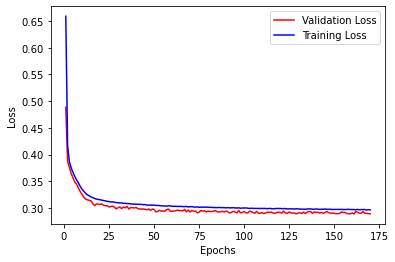

In [ ]:
import matplotlib.pyplot as plt
val_loss = history_retrieval_snow.history["val_mean_absolute_error"]
loss = history_retrieval_snow.history["mean_absolute_error"]

epochs = range(1, 171)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
predictions_snow = model_retrieval_snow.predict(Xf_snow_tst_retrieval)

In [ ]:
model_retrieval_snow.evaluate(Xf_snow_tst_retrieval, yf_snow_tst_retrieval, batch_size = batch_size2)

126/126 [==============================] - 0s 665us/step - loss: 0.5972 - mean_absolute_error: 0.3043


[0.5972467660903931, 0.3043079078197479]

# Checking Outputs

### **2.2.1 Rainfall retrieval**

In [ ]:
# Parameters
hidden_units = 90
dropout = 0

# COAST
model_retrieval_rain = Sequential()

model_retrieval_rain.add(Dense(hidden_units))
model_retrieval_rain.add(Activation('relu'))
model_retrieval_rain.add(Dropout(dropout))

model_retrieval_rain.add(Dense(hidden_units))
model_retrieval_rain.add(Activation('relu'))
model_retrieval_rain.add(Dropout(dropout))

model_retrieval_rain.add(Dense(hidden_units))
model_retrieval_rain.add(Activation('relu'))
model_retrieval_rain.add(Dropout(dropout))

model_retrieval_rain.add(Dense(hidden_units))
model_retrieval_rain.add(Activation('relu'))
model_retrieval_rain.add(Dropout(dropout))

model_retrieval_rain.add(Dense(hidden_units))
model_retrieval_rain.add(Activation('relu'))
model_retrieval_rain.add(Dropout(dropout))

model_retrieval_rain.add(Dense(hidden_units))
model_retrieval_rain.add(Activation('relu'))
model_retrieval_rain.add(Dropout(dropout))

model_retrieval_rain.add(Dense(1))
model_retrieval_rain.add(Activation('relu'))

In [ ]:
model_retrieval_rain.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              loss = root_mean_squared_error,
              metrics= mean_absolute_error)

In [ ]:
from tensorflow import keras
callbacks_list = [
    keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=25,),
    keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    )    
]

In [ ]:
print('\nFitting DNN (Retrieval Module - Rain):\n')
batch_size2 = 600
history_retrieval_rain = model_retrieval_rain.fit(Xf_rain_trn_retrieval, yf_rain_trn_retrieval, epochs=500,
                                validation_split=.2, batch_size = batch_size2,
                                callbacks=callbacks_list, verbose=1)


Fitting DNN (Retrieval Module - Rain):

Epoch 1/500
234/234 [==============================] - 1s 5ms/step - loss: 5.6829 - mean_absolute_error: 2.2335 - val_loss: 5.5839 - val_mean_absolute_error: 2.0815
Epoch 2/500
234/234 [==============================] - 1s 4ms/step - loss: 5.3156 - mean_absolute_error: 1.9165 - val_loss: 5.1809 - val_mean_absolute_error: 1.8070
Epoch 3/500
234/234 [==============================] - 1s 4ms/step - loss: 4.9547 - mean_absolute_error: 1.7432 - val_loss: 4.8670 - val_mean_absolute_error: 1.7385
Epoch 4/500
234/234 [==============================] - 1s 5ms/step - loss: 4.7636 - mean_absolute_error: 1.7613 - val_loss: 4.7804 - val_mean_absolute_error: 1.7864
Epoch 5/500
234/234 [==============================] - 1s 5ms/step - loss: 4.7103 - mean_absolute_error: 1.7963 - val_loss: 4.7380 - val_mean_absolute_error: 1.7966
Epoch 6/500
234/234 [==============================] - 1s 5ms/step - loss: 4.6684 - mean_absolute_error: 1.8008 - val_loss: 4.7003 - v

234/234 [==============================] - 1s 5ms/step - loss: 3.8016 - mean_absolute_error: 1.2902 - val_loss: 3.8592 - val_mean_absolute_error: 1.2957
Epoch 100/500
234/234 [==============================] - 1s 5ms/step - loss: 3.8018 - mean_absolute_error: 1.2924 - val_loss: 3.8581 - val_mean_absolute_error: 1.3009
Epoch 101/500
234/234 [==============================] - 1s 4ms/step - loss: 3.7999 - mean_absolute_error: 1.2915 - val_loss: 3.8613 - val_mean_absolute_error: 1.2630
Epoch 102/500
234/234 [==============================] - 1s 5ms/step - loss: 3.7923 - mean_absolute_error: 1.2900 - val_loss: 3.8543 - val_mean_absolute_error: 1.2934
Epoch 103/500
234/234 [==============================] - 1s 5ms/step - loss: 3.7894 - mean_absolute_error: 1.2894 - val_loss: 3.8524 - val_mean_absolute_error: 1.2919
Epoch 104/500
234/234 [==============================] - 1s 5ms/step - loss: 3.7758 - mean_absolute_error: 1.2898 - val_loss: 3.8509 - val_mean_absolute_error: 1.2881
Epoch 105/50

234/234 [==============================] - 1s 5ms/step - loss: 3.6355 - mean_absolute_error: 1.2555 - val_loss: 3.7416 - val_mean_absolute_error: 1.2519
Epoch 198/500
234/234 [==============================] - 1s 5ms/step - loss: 3.6237 - mean_absolute_error: 1.2538 - val_loss: 3.7407 - val_mean_absolute_error: 1.2646
Epoch 199/500
234/234 [==============================] - 1s 5ms/step - loss: 3.6172 - mean_absolute_error: 1.2531 - val_loss: 3.7404 - val_mean_absolute_error: 1.2485
Epoch 200/500
234/234 [==============================] - 1s 5ms/step - loss: 3.6194 - mean_absolute_error: 1.2506 - val_loss: 3.7403 - val_mean_absolute_error: 1.2493
Epoch 201/500
234/234 [==============================] - 1s 4ms/step - loss: 3.6326 - mean_absolute_error: 1.2525 - val_loss: 3.7368 - val_mean_absolute_error: 1.2599
Epoch 202/500
234/234 [==============================] - 1s 4ms/step - loss: 3.6300 - mean_absolute_error: 1.2577 - val_loss: 3.7405 - val_mean_absolute_error: 1.2809
Epoch 203/50

234/234 [==============================] - 1s 4ms/step - loss: 3.4988 - mean_absolute_error: 1.2371 - val_loss: 3.7267 - val_mean_absolute_error: 1.2642
Epoch 296/500
234/234 [==============================] - 1s 4ms/step - loss: 3.5084 - mean_absolute_error: 1.2416 - val_loss: 3.7277 - val_mean_absolute_error: 1.2704
Epoch 297/500
234/234 [==============================] - 1s 4ms/step - loss: 3.5108 - mean_absolute_error: 1.2392 - val_loss: 3.7304 - val_mean_absolute_error: 1.2745
Epoch 298/500
234/234 [==============================] - 1s 4ms/step - loss: 3.5006 - mean_absolute_error: 1.2388 - val_loss: 3.7270 - val_mean_absolute_error: 1.2632
Epoch 299/500
234/234 [==============================] - 1s 4ms/step - loss: 3.4966 - mean_absolute_error: 1.2407 - val_loss: 3.7284 - val_mean_absolute_error: 1.2623
Epoch 300/500
234/234 [==============================] - 1s 4ms/step - loss: 3.4949 - mean_absolute_error: 1.2383 - val_loss: 3.7253 - val_mean_absolute_error: 1.2699
Epoch 301/50

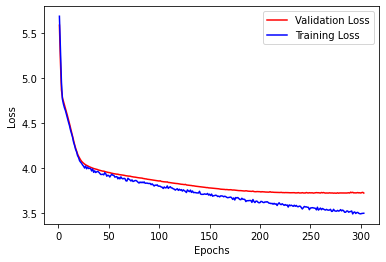

In [ ]:
val_loss = history_retrieval_rain.history["val_loss"]
loss = history_retrieval_rain.history["loss"]

epochs = range(1, 304)
plt.plot(epochs, val_loss[:], "r-",
label="Validation Loss")
plt.plot(epochs, loss[:], "b-",
label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
predictions_rain = model_retrieval_rain.predict(Xf_rain_tst_retrieval)

In [ ]:
model_retrieval_rain.evaluate(Xf_rain_tst_retrieval, yf_rain_tst_retrieval, batch_size = batch_size2)

125/125 [==============================] - 0s 862us/step - loss: 3.9410 - mean_absolute_error: 1.3309


[3.941049098968506, 1.3308517932891846]

# **3. Saving the models**

In [ ]:
import scipy
from scipy.io import savemat

model_detection.save('Models\DPR\Coast\model_dtc',save_format='h5')
model_retrieval_snow.save('Models\DPR\Coast\model_snow',save_format='h5')
model_retrieval_rain.save('Models\DPR\Coast\model_rain',save_format='h5')

fp_DPR_coast = 'Models/DPR/coast/files_DPR_coast.mat'
scipy.io.savemat(fp_DPR_coast, {'mean_detection_DPR_coast': mean_detection,'std_detection_DPR_coast':std_detection,
                               'mean_snow_retrieval_DPR_coast': mean_snow_retrieval,'std_snow_retrieval_DPR_coast':std_snow_retrieval,
                               'mean_rain_retrieval_DPR_coast': mean_rain_retrieval,'std_rain_retrieval_DPR_coast':std_rain_retrieval})
